In [1]:
using PyPlot
using ArrayViews
include("nbody_helper.jl");

In [2]:
"""
An object witch has gravity.
This is either a MassPoint or a BarnesHutTree.
"""
abstract Object

In [3]:
"""
A single point with a mass and position.
It dosen't store it's velocity, because we use verlet integration.
"""
immutable MassPoint <: Object
    mass::Float64
    position::Vector{Float64}
end

In [4]:
"""
A bounding box in 3D
"""
immutable SpaceBox
    lower::Vector{Float64}
    upper::Vector{Float64}
end

In [5]:
"""
Find the bounding box for a set of mass points.
Returns a SpaceBox
"""
function bounding_box(mass_points::Vector{MassPoint})
    l = Array(Float64, 3)
    u = Array(Float64, 3)
    for i in 1:3
        xs = map(p -> p.position[i], mass_points) # TODO: optimize!
        l[i] = minimum(xs)
        u[i] = maximum(xs)
    end
    return SpaceBox(l, u)
end

bounding_box (generic function with 1 method)

In [6]:
"""
Split the box on each dimension in two parts (lower and upper).
Returns a 3D array with all sub boxes.
"""
function split_box(box::SpaceBox) # TODO: test!
    half_spanning = (box.upper - box.lower) ./ 2.0
    boxes = Array(SpaceBox, 2, 2, 2)
    for i in 1:2, j in 1:2, k in 1:2 # iterate over all sub boxes
        low = Array(Float64, 3)
        up = Array(Float64, 3)
        index = [i, j, k] # index into the box array
        for l in 1:3 # iterate over all 3 dimensions
            low[l] = box.lower[l] + (index[l] - 1)*half_spanning[l]
            up[l] = low[l] + half_spanning[l]
        end
        boxes[i, j, k] = SpaceBox(low, up)
    end
    return boxes
end

split_box (generic function with 1 method)

In [7]:
"""
An octtree with masses and positions of all point sets. (Barnes Hut Tree)
"""
immutable BarnesHutTree <: Object
    box::SpaceBox
    sub_tries::Array{Nullable{Object}, 3}
    total_mass::Float64
    mass_center_position::Vector{Float64}
end

In [8]:
"""
Creates an barnes hut tree from a given list of mass points
"""
function make_tree(mass_points::Vector{MassPoint})
    return make_tree(mass_points, bounding_box(mass_points))
end

make_tree (generic function with 1 method)

In [18]:
function make_tree(mass_points::Vector{MassPoint}, box::SpaceBox) # -> Nullable{Object}
    if size(mass_points, 1) == 0
        return Nullable{BarnesHutTree}()
    elseif size(mass_points, 1) == 1
        return Nullable(mass_points[1])
    else
        center = (box.upper + box.lower)/2
        sub_boxes = split_box(box)
        sub_point_boxes = Array(Vector{MassPoint}, 2, 2, 2)
        for i in eachindex(sub_point_boxes); sub_point_boxes[i] = MassPoint[] end
        total_mass = 0.0
        mass_center_position = zeros(3)
        for p in mass_points
            i = p.position[1] < center[1] ? 1 : 2
            j = p.position[2] < center[2] ? 1 : 2
            k = p.position[3] < center[3] ? 1 : 2
            push!(sub_point_boxes[i, j, k], p)

            total_mass += p.mass
            mass_center_position += p.position
        end
        mass_center_position /= size(mass_points, 1)
        sub_tries = map(make_tree, sub_point_boxes, sub_boxes)
        tree = BarnesHutTree(box, sub_tries, total_mass, mass_center_position)
        return Nullable(tree)
    end
end

make_tree (generic function with 2 methods)

In [19]:
"""
Constant of gravity in SI units (m^3/s^2/kg)
"""
const G = 6.67e-11

Constant of gravity in SI units (m^3/s^2/kg)


In [20]:
"""
Acceleration of the given masspoint `on` according to the gravitational force of `from`.
"""
function accel_on(on::MassPoint, from::MassPoint)
    between = from.position - on.position
    d = norm(between)
    if d == 0
        return zeros(3)
    else
        return G*from.mass/d^3*between
    end
end

accel_on (generic function with 2 methods)

In [21]:
function accel_on(on::MassPoint, from::BarnesHutTree)
    r = norm(from.box.lower - from.box.upper)
    d = norm(on.position - from.mass_center_position)
    if d != 0 && r/d < 1
        # the object is far away -> use the tree itself
        eq_mass_point = MassPoint(from.total_mass, from.mass_center_position)
        return accel_on(on, eq_mass_point)
    else
        # it is close -> use sub tires
        total_force = zeros(3)
        for sub_tree in from.sub_tries
            if !isnull(sub_tree)
                total_force += accel_on(on, get(sub_tree))
            end
        end
        return total_force
    end
end

accel_on (generic function with 2 methods)

In [22]:
"""
Returns a matrix of the movement of all `mass_points` in a time `T`, every `h` seconds.
The columns are the steps in time, The rows are the induvidual particles.
"""
function simulate(mass_points::Vector{MassPoint}, vs::Vector{Vector{Float64}}, time::Float64, h::Float64)
    @assert(size(mass_points, 1) >= 2)
    steps = Int64(floor(time/h))
    xs = Array(MassPoint, size(mass_points, 1), steps)
    @inbounds xs[:, 1] = mass_points
    bht = get(make_tree(mass_points))
    # xs[:, 2] = [MassPoint(mp.mass, mp.position + h*v + 0.5*accel_on(mp, bht)) for (mp, v) in zip(mass_points, vs)]
    for i in 1:size(mass_points, 1)
        @inbounds xs[i, 2] = MassPoint(xs[i, 1].mass,  xs[i, 1].position + h*vs[i] + 0.5*accel_on(xs[i, 1], bht))
    end
    for i in 3:steps
        @inbounds bht = get(make_tree(xs[:, i - 1]))
        #xs[i, :] = [MassPoint(mp1.mass, 2*mp1.position - mp2.position + accel_on(mp1, bht)*h^2)
        #           for (mp1, mp2) in zip(xs[i - 1,:], xs[i - 2,:])]
        for j in 1:size(mass_points, 1)
            @inbounds xs[j, i] = MassPoint(xs[j, i - 1].mass, 
                2*xs[j, i - 1].position - xs[j, i - 2].position + accel_on(xs[j, i - 1], bht)*h^2)
        end
    end
    return xs
end

simulate (generic function with 1 method)

In [63]:
n = 100;
r = 1e4
v = 1e2
T = 1e10;
steps = 500
h = T / steps;
axis = [0., 0., 1.]
function rand_point()
    a = rand()*2*pi
    b = rand()*2*pi
    return [r*sin(a)*cos(b), r*sin(a)*sin(b), r*cos(a)]
end
function rand_velocity()
    a = rand()*2*pi
    return [0., v*sin(a), v*cos(a)]
end
ps = [MassPoint(rand()*1e6, rand_point()) for i in 1:n];
vs = Vector{Float64}[rand_velocity() for i in 1:n];
push!(ps, MassPoint(1e15, zeros(3)))
push!(vs, zeros(3));

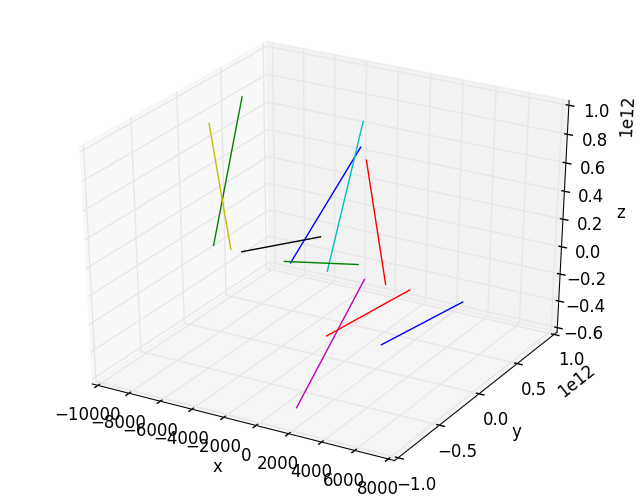

  3.475130 seconds (22.93 M allocations: 1.300 GB, 29.72% gc time)
  5.666873 seconds (3.25 k allocations: 765.719 KB)


In [64]:
@time res = simulate(ps, vs, T, h);
@time plot_orbits(res[1:10, :])

In [ ]:
function plot_stuff(res)
    plot_points = 100
    step = div(size(res, 2), plot_points)
    for i in 1:size(res, 1)
        x = [res[i, j].position[1] for j in 1:step:size(res, 2)]
        y = [res[i, j].position[2] for j in 1:step:size(res, 2)]
        z = [res[i, j].position[3] for j in 1:step:size(res, 2)]
        plot3D(x, y, z)
    end
    xlabel("x")
    ylabel("y")
    zlabel("z")
    show()
end